## Boiler Plate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing libaries

In [5]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

In [59]:
path = Path('../data/caltech101/')

## Loading Data and Model

In [9]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

In [79]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 102
['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'se

In [31]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 7316
Test dataset size: 1828


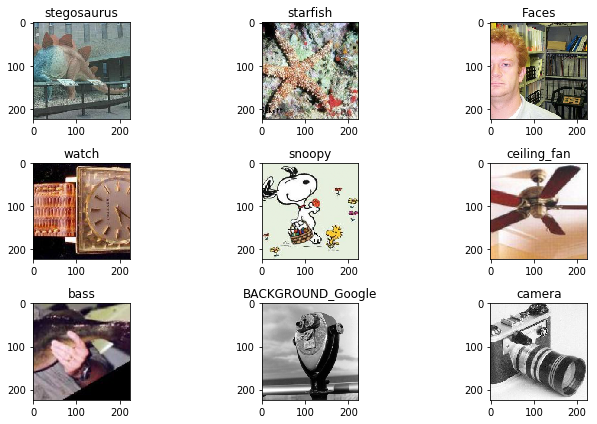

In [15]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False) 

In [10]:
## Creating the model
learn = create_cnn(data, models.resnet34, pretrained=True, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 81878722.28it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


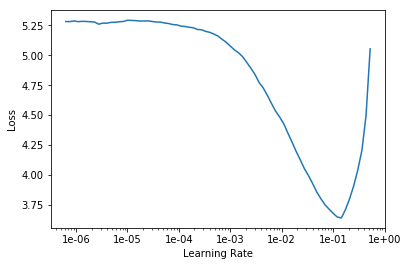

In [14]:
## Finding Ideal learning late
learn.lr_find()
learn.recorder.plot()

In [16]:
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.267370,0.531669,0.850109
2,0.909400,0.723123,0.794858
3,0.575022,0.440530,0.870350
4,0.294055,0.236871,0.928884
5,0.161143,0.207409,0.939825


In [17]:
## Saving stage 1
learn.save('stg1-rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


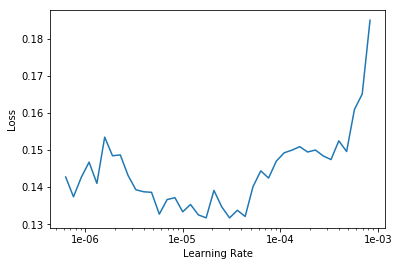

In [19]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
## Fitting 5 epochs
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy
1,0.161009,0.261251,0.923414
2,0.263622,0.350632,0.903720
3,0.146714,0.249182,0.931072
4,0.070570,0.192343,0.947484
5,0.035966,0.180224,0.951860


In [33]:
## Saving model weights
learn.save('stg2-rn34')

## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a 4096 length vector for a particular image of 256*256.

In [34]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

Creating Feature Vector

In [35]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

Converting in a dictionary of {img_path:featurevector}

In [40]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [49]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

## Using Locality Sensitive hashing to find near similar images

In [50]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [60]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [61]:
## Exporting as pickle
pickle.dump(lsh, open(path/'lsh.p', "wb"))

## Visualizing Output

In [69]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

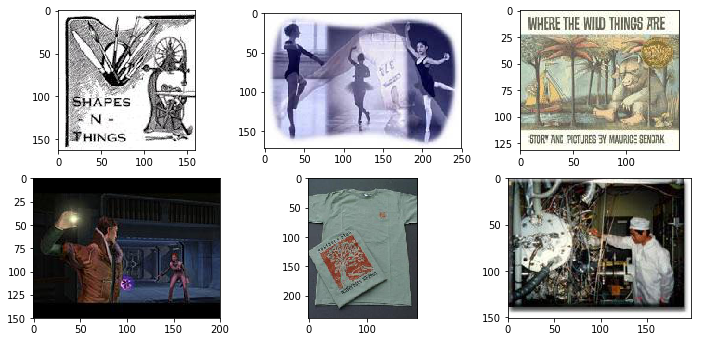

In [70]:
get_similar_item(0, feature_dict, lsh,5)

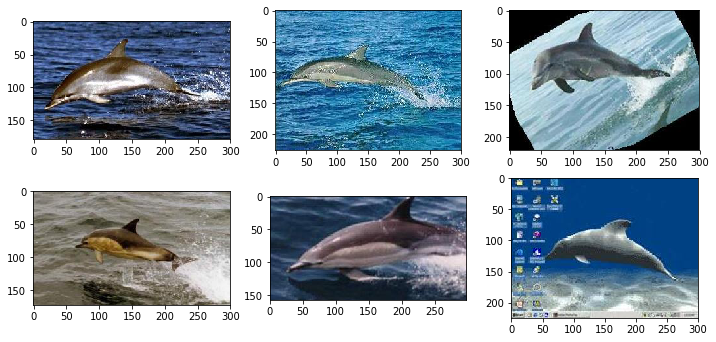

In [71]:
get_similar_item(1000, feature_dict, lsh,5)

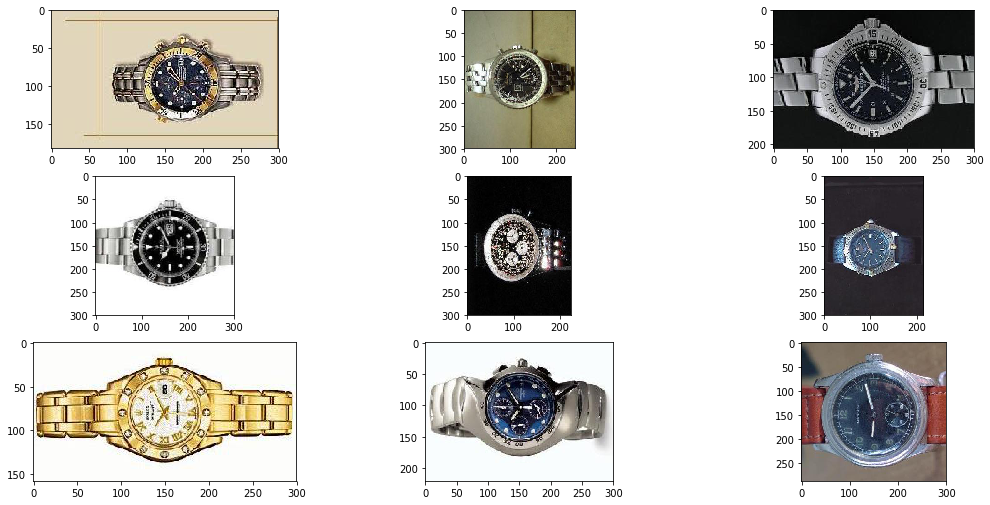

In [78]:
get_similar_item(2000, feature_dict, lsh, 8)

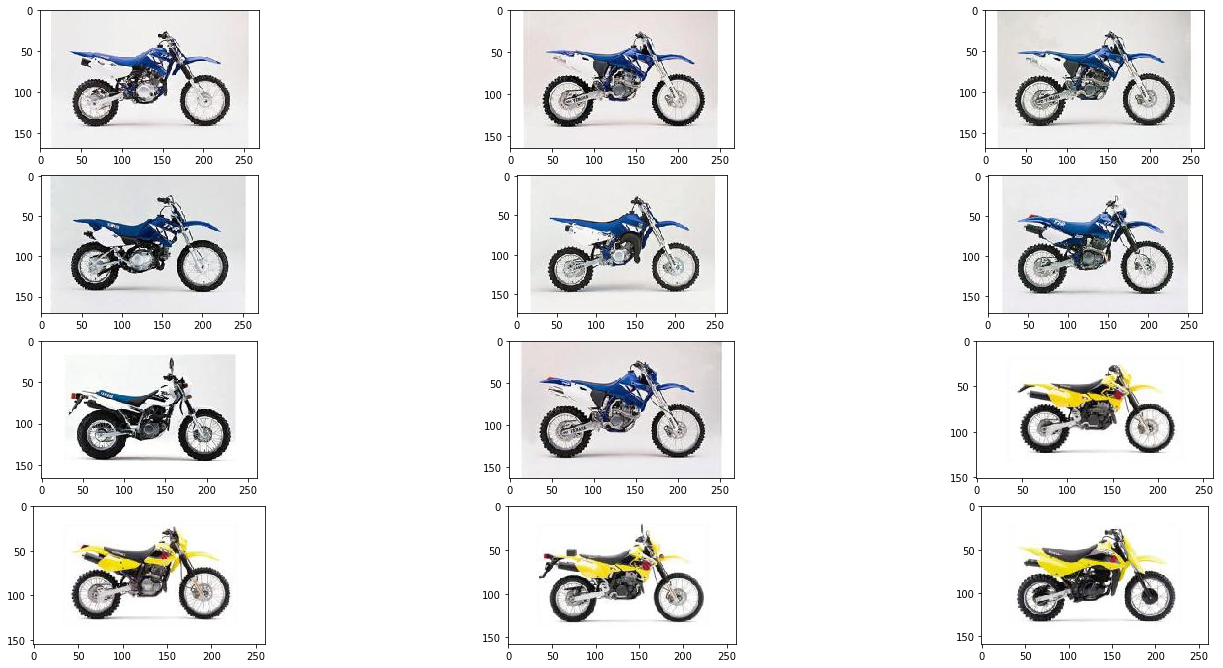

In [73]:
get_similar_item(3000, feature_dict, lsh,11)

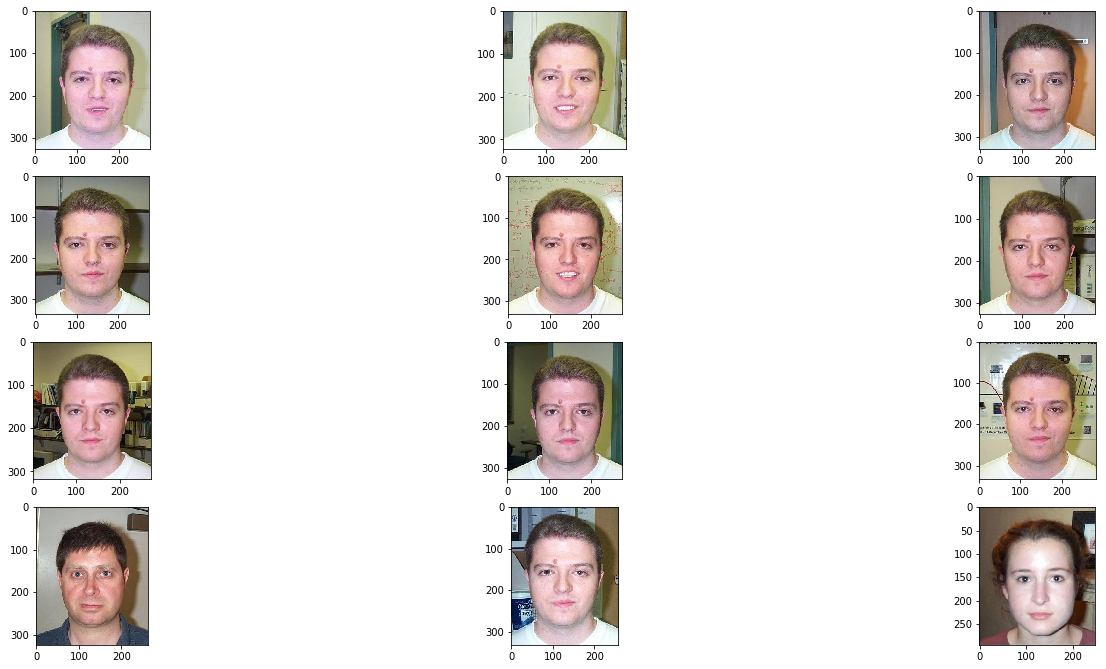

In [74]:
get_similar_item(4000, feature_dict, lsh,11)

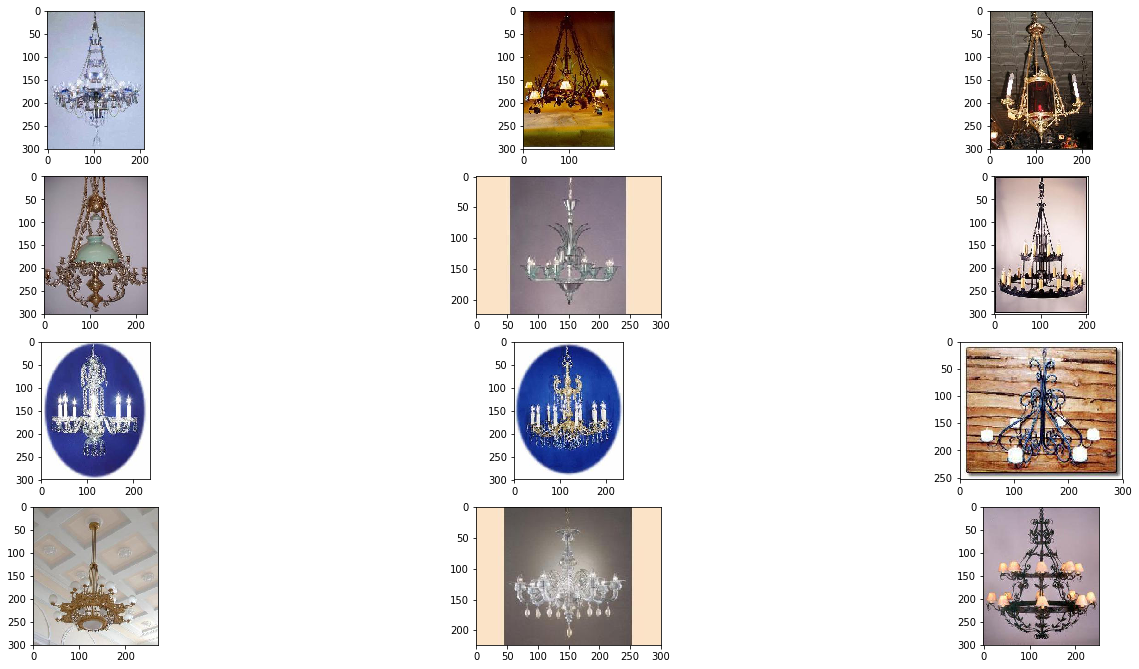

In [75]:
get_similar_item(5000, feature_dict, lsh,11)